In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph, radius_neighbors_graph
from sklearn.metrics import pairwise_distances as all_dist
import networkx as nx

In [0]:
def GeoDist(data, method='K', param=4):
    n = data.shape[0]
    if method == 'K':
        edges = kneighbors_graph(data, param, mode='distance').toarray()
    elif method == 'e':
        edges = radius_neighbors_graph(data, param, mode='distance').toarray()
    edges[edges==0] = np.inf
    np.fill_diagonal(edges,0)
    G = nx.Graph()
    for i in range(n):
        for j in range(i+1, n):
            G.add_edge(i,j,weight=edges[i,j])
    return nx.algorithms.shortest_paths.dense.floyd_warshall_numpy(G)  

triu = np.triu_indices

In [0]:
class CDA:
    def __init__(self, p, alfa, lambda_, method='K', params=20):
        self.p = p
        self.alfa = alfa
        self.lambda_ = lambda_
        self.method = method
        self.params = params

    def stress(self, dist_y, dist_x):
        dy = np.ravel(dist_y[self.triu])
        dx = dist_x[self.triu]
        return np.sum( (dy-dx)**2 * np.heaviside(self.lambda_ - dx, 0.5) )

    def transform(self, data): # Done
        pca = PCA(n_components=self.p)
        return pca.fit_transform(data)

    def run(self, data_y, q_max=10, show=False):
        dist_y = GeoDist(data_y, self.method, self.params)
        data_x = self.transform(data_y)
        n = data_x.shape[0]
        self.triu = triu(dist_y.shape[0],1)
        dist_x = all_dist(data_x)
        stress = np.zeros(q_max)
        for q in range(q_max):
            for i in range(n):
                s3=time.time()
                dx = np.delete(dist_x[i,:], i, 0)
                dy = np.delete(np.ravel(dist_y[i,:]), i, 0)
                fact = np.heaviside(self.lambda_ - dx,0.5)*(dy-dx)/dx
                delta_x = fact.reshape((-1,1))*np.delete(data_x - data_x[i,:], i, 0)
                data_x[:i, :] += self.alfa*delta_x[:i, :]
                data_x[i+1:, :] += self.alfa*delta_x[i:, :]
                dist_x = all_dist(data_x)
            stress[q] = self.stress(dist_y, dist_x)
        if show:
            plt.plot(np.arange(q_max), stress)
            plt.show()
        print(stress[-1])
        return data_x

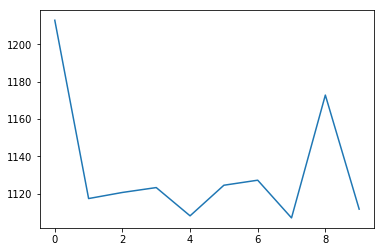

1111.6809083559492


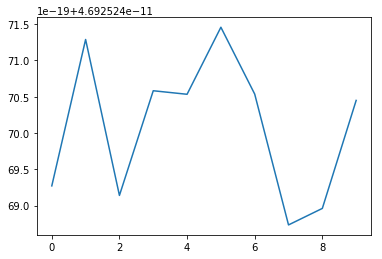

4.6925247044911354e-11


In [0]:
data = np.random.random((1000,2))
a = CDA(1, 0.3, 0.5)
r = a.run(data, q_max=10, show=True)

data[:,1] = np.cos(data[:,0])

a = CDA(1, 0.3, 0.5)
r = a.run(data, q_max=10, show=True)